# $\ell_1$ periodogram - application to HD 158259

The $\ell_1$ periodogram (Hara, Boué, Laskar & Correia 2017, MNRAS, 464, 1, p.1220-1246) is a data analysis tool aiming at finding periodicities in time-series. It is in particular designed to search for exoplanets in radial velocity data. In this notebook, a few usage examples are given. 

The $\ell_1$ periodogram can be used similarly to a Lomb-Scargle periodogram or its variants (e. g. Baluev 2008), but relies on a different principle. In both Lomb-Scargle-type and $\ell_1$ periodograms, one defines a frequency grid. In the first case, one fits a sinusoidal function at each frequency in the grid. In the $\ell_1$ periodogram, one searches directly for a representation of the input signal as a sum of sinusoids whose frequencies are in the input frequency grid. In a sense, all the frequencies of the signal are searched simultaneously. 

To be able to solve this seemingly ill-posed problem, we assume that the number of frequency in the signal is much smaller than the number of observations. In the context of exoplanets, is is reasonable to assume that there are most $\approx$ 15 distinct periodicities in the radial velocities, while there are typically $\geqslant$ 50-70 data points. We can then rely on the so-called "sparse recovery" tools, which are designed to find a representation of an input signal as a linear combination of a few entries of a given "dictionary" (here sine functions). The $\ell_1$ periodogram relies more precisely on the basis pursuit problem (Chen & Donoho 1998) and the group-LASSO (Yuan & Lin 2006).

The analysis of radial velocities can be difficult due to the presence of complicated noises and the fact that the data comes from different instruments. The $\ell_1$ periodogram can handle different instruments, correlated noise models, trends and linear stellar activity models.

We will cover basic uses of the $\ell_1$ periodogram and more advanced ones. We always follow three steps:
1. Load the data in the class l1p_class
2. Define the frequency grid, noise model, signal model
3. Launch the computation of the l1 periodogram

We here apply it to the HD 158259 SOPHIE data (Hara et al. 2020, A&A, 636, L6)
We always assume that the time is given in days and the radial velocity in m/s


In [1]:
#First, a few imports
import numpy as np
import matplotlib.pyplot as plt

import sys, os

dir_path = os.path.dirname(os.path.realpath('l1_periodogram_tutorial_I.ipynb'))
subdir = os.path.join(dir_path,'l1periodogram_codes')
if subdir not in sys.path:
    sys.path.append(subdir)


import l1periodogram_v1
import covariance_matrices
import combine_timeseries
import filter_poly

filepath = 'Data/'

To use gglasso, run the command python -m numpy.f2py -c gglasso.f90 -m gglasso_wrapper in the directory l1periodogram_codes, then restart the kernel.


The first data set we analyse is 74 HARPS measurements of HD 69830, that permitted the detection of three Neptunes (Lovis et al. 2006, A&A)

In [2]:
dataset_names = ['HD158259_SOPHIE_OHPc.rdb']
dataset_path = [filepath+d for i,d in enumerate(dataset_names)]

#Load the data from the file
T,y,err,offsets,dico, dict_out, dataset_names_out = \
                        combine_timeseries.create_dataset(dataset_path,
                                outlier_cond = 3.5,
                         bintimescale = 0.0)

In [3]:
#Dictionary containing the info on points excluded from the analysis (outliers)
print(dict_out)

{'T_removed_init': array([57941.5059, 57944.4063, 57945.4585]), 'y_removed_init': array([0.1163631, 0.0209631, 0.0224631]), 'err_removed_init': array([0.001 , 0.0011, 0.0011]), 'T_removed_afterdrift': array([], dtype=float64), 'y_removed_afterdrift': array([], dtype=float64), 'err_removed_afterdrift': array([], dtype=float64)}


------------- 

## Three step process to compute the $\ell_1$ periogogram.
### Step 1. Load the data in the class 

In [4]:
#T is the measurement times and y is the time series to analyse
c = l1periodogram_v1.l1p_class(T,y)
# You now have access to the time of observations and time series c.t_init and c.y_init
# For numerical stability, we will now consider these same values but centeresd
# c.t = c.t_init - np.mean(c.t_init)
# c.y = c.y_init - np.mean(c.y_init)

# You might want to give names of the star under consideration, the datasets and the offsets (for plots)
c.starname = 'HD 158259'
c.dataset_names = dataset_names_out
c.offsets = offsets

<span style="color:#8B0000;font-size:12pt">
You might be surprised that error bars were not mentionned, it's coming now
</span>

### Step 2. Define the model

We now need to define several elements of the signal model

- The frequency grid (class attribute "omegas"): the signal will be decomposed as sinusoids on this grid 
- The noise model (class attribute "V"), in the form of the assumed covariance matrix of the noise
- The vectors assumed to be in the model, (class attribute "MH0"). There might be vectors that are known to be in the data, such as an offset, a trend, or a linear activity model, that we want to include by default in the model. 

In the following examples, we use a simple covariance model, where the covariance matrix is defined as:
<span style="font-size:12pt">
$$V_{kl} = \delta_{kl}(\sigma_k^2 + \sigma_W^2) + \sigma_R^2 \mathrm{e}^{-\frac{(t_k-t_l)^2}{2\tau^2}} $$
</span>
where $\sigma_W$ (m/s), $\sigma_R$ (m/s)and $\tau$ (d) are user defined. 

Creating dictionary
Projection matrix set, dimension of the unconstrained space (number of MH0 columns): 1
Model creation duration 1.0149424076080322 seconds


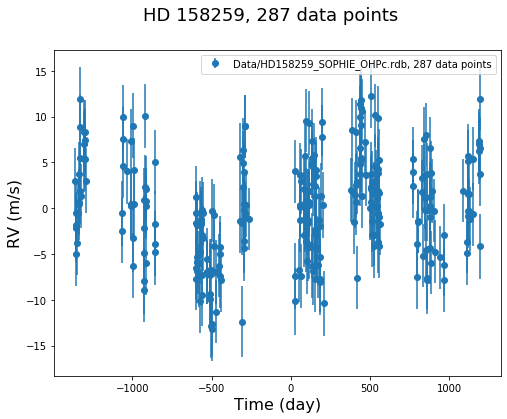

In [5]:
#We define a covariance model
sigmaW = 2.5 #We add in quadrature 1 m/s to the nominal HARPS errors 
sigmaR, tau = 2. ,6. #red noise
sigma_calib = 0.75 #No calibration noise
V = covariance_matrices.covar_mat(T,err, sigmaW, 
                                  sigmaR,sigma_calib,tau, kernel='exponential')

#To set the model use the method:
c.set_model(omegamax = 1.4*np.pi, #We will search frequencies up to 0.7 cycles/day = 3*np.pi rad/day
                  V = V,
                MH0 = offsets)#The only vector we assumed to be in the data by default is the offset

#Now the noise model is defined, let us plot the data
#The error bars are the square root of the diagonal of V
c.plot_input_data()

### Step 3. Run the $\ell_1$ periodogram

We have defined what is needed to compute the $\ell_1$ periodogram.

We here define: 
- The numerical method that will be used to solve the basis pursuit model (class attribute "numerical_method"). Depending on this, the dictionary columns may need to be normalized or orthonormalized. By default, we use the LARS algorithm with lasso modification (Efron, Hastie, Johnstone, Tibshirani 2004, Ann. Stat.), one can also use gglasso (Yang, Y. and Zou, H.(2015)). 
- Once the $\ell_1$ periodogram is computed, we want to determine whether the peaks are significant. We here set the methods to evaluate the significance: ['faps', 'evidence_laplace'], that are false alarm probabilities and Laplace approximation of Bayesian evidences. We also define that the significance tests will be done on the max_n_significance_tests=5 highest peaks of the $\ell_1$ periodogram.

Note that as compared to Hara et al. 2020, A&A, 636, L6, the smoothing procedure of the l1-periodogram has been changed slightly, so that the amplitude of the paks differ from the original publication. 

--------- l1 periodogram: start ---------
Setting minimization input
Weighting the dictionary
Weighting dictionary duration 0.9546718597412109 seconds
Dictionary columns centred
Dictionary columns normalized
Computing LARS path
Number of lasso modifications in lars:  8 in 71 iterations
LARS duration 2.4456450939178467 seconds
Smoothing lasso solution
Smoothing duration  0.062005043029785156 seconds
Find peaks duration 0.008128166198730469 seconds
Plot (clean) duration  0.31386518478393555 seconds
Evaluating peaks significance
Significance evaluation 1 / 12
Significance evaluation 2 / 12
Significance evaluation 3 / 12
Significance evaluation 4 / 12
Significance evaluation 5 / 12
Significance evaluation 6 / 12
Significance evaluation 7 / 12
Significance evaluation 8 / 12
Significance evaluation 9 / 12
Significance evaluation 10 / 12
Significance evaluation 11 / 12
Significance evaluation 12 / 12
Significance evaluation duration 4.115515947341919 seconds
Plot (with list) duration  0.36332

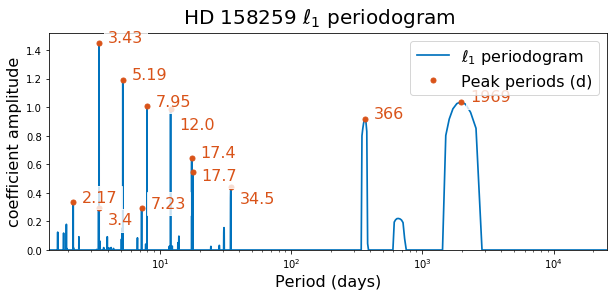

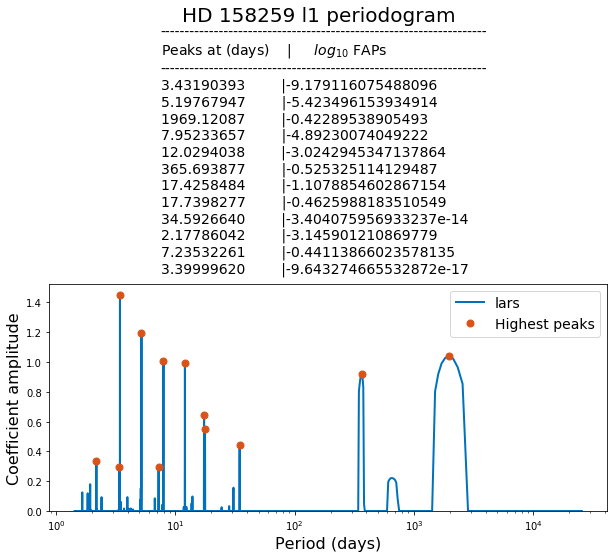

In [11]:
c.l1_perio(numerical_method='lars',
           significance_evaluation_methods = ['fap','evidence_laplace'],
           max_n_significance_tests=12,verbose=1)

------------- 

## Outputs

The two output plots show the same figure: the amplitude of the coefficients of the periodogram as a function of frequency. The upper one is intended for publications and the second is intended for analysis purposes. They can be computed after running the l1_perio method through the methods "plot_clean" and "plot_with_list". In the plot_clean method, you can specify which peaks annotations you want (see below). 

We find several peaks in the $\ell_1$ periodogram. In the second plot, they are listed by decreasing amplitude along with a significance threshold, which is computed as described in Hara, Boué, Laskar, Correia 2017. That is, we compute a sequence of false alarm probabilities of periodograms where the base models are a sequence of $n$ planets models at the $n$ tallest peaks of the $\ell_1$ periodogram. Here, we compare {signal at 3.432 d + MH0 linear model} vs {MH0 linear model}, then {signal at 3.432 d + signal at 370 d + MH0 linear model} vs {signal at 3.432 d + MH0 linear model} and so on. 

We can compare these models with approximate evidence calculations (laplace approximation) as described in Nelson, Ford, et al. 2018, AJ, see Appendix A.4.). We can plot the same figures with this significance metric. You can also access the frequencies and values of the peaks with the attributes "omega_peaks" and "peakvalues". The significance values are accessible as elements of the "significance" attributes, which is a Python dictionary. 

Below, we plot 
1. The l1-periodogram with approximate Bayes factor labels instead of periods
2. The l1-periodogram with the list of Bayes factors periods
3. The l1-periodogram based on the attributes of the class c, to show what exactly is plotted 

Peaks at  [3.43190393e+00 3.70993789e+02 1.96912088e+03 5.19767948e+00
 1.20350594e+01 7.95233657e+00 1.74139942e+01 6.39964286e+02
 1.77398277e+01 3.45926641e+01 1.83977084e+00 5.12689193e+00]  days
With amplitude  [1.31206942 1.07485611 1.06459892 0.97470594 0.88292715 0.80115111
 0.65019004 0.49128783 0.40700639 0.38032548 0.19144902 0.11731071
 0.08791735 0.08314198 0.07640429 0.03475325 0.0294194  0.02443516]
With log10fap  [-4.38464483e+00 -4.71684482e+00 -4.48589516e-01 -4.39905197e+00
 -3.91758139e+00 -3.41357156e+00 -2.43438694e+00 -1.55540692e+00
 -2.41697882e-01 -1.69364060e-07 -9.31898970e-01  0.00000000e+00]
With approx. log10 evidence   [11.77850356 10.88945356  3.18114025  7.73339737  5.86135338  4.21978662
  2.86438478  1.52091841  0.12153324 -0.89530602 -0.09683966 -2.10501126]


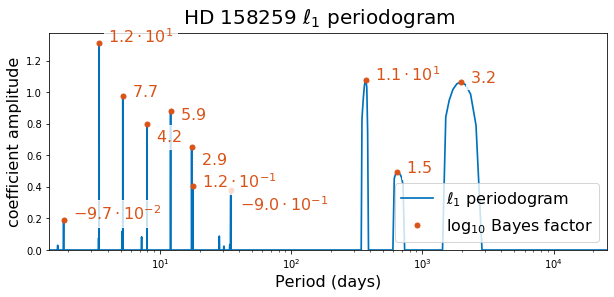

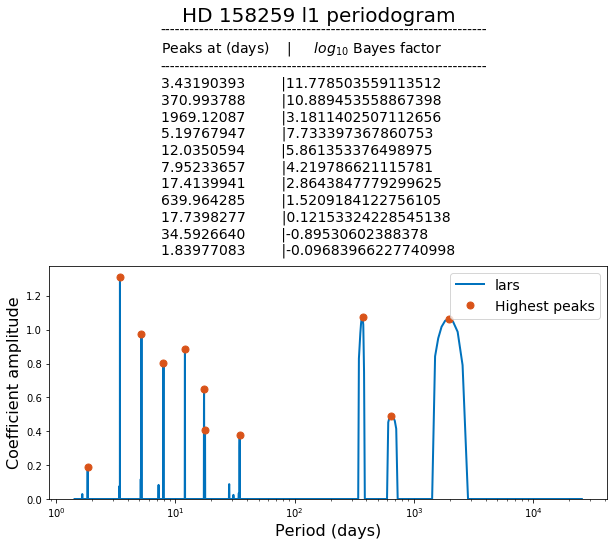

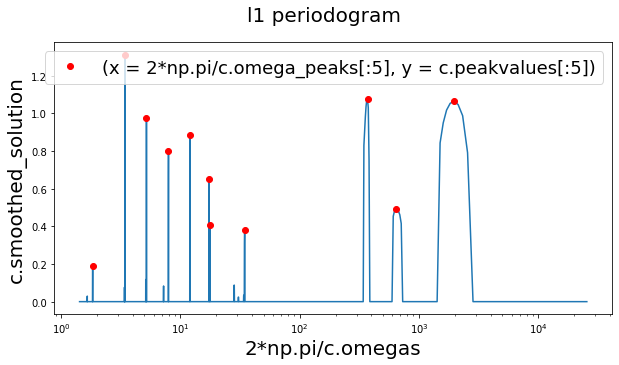

In [7]:
#We highlight the  highest peaks 
c.plot_clean(11, annotations = 'log10_bayesf_laplace', save = False)
c.plot_with_list(11, significance_values = 'log10_bayesf_laplace', save = False)
#The keyword saves determines if the plot is saved or not

print('Peaks at ', 2*np.pi/c.omega_peaks[:12], ' days')
print('With amplitude ', c.peakvalues)
print('With log10fap ', c.significance['log10faps'])
print('With approx. log10 evidence  ', c.significance['log10_bayesf_laplace'])

#The value of the l1 periodogram abscissa and ordinates respectively are c.omegas and c.smoothed_solution
plt.figure(figsize=(10,5))
plt.suptitle('l1 periodogram', fontsize=20)
plt.semilogx(2*np.pi/c.omegas, c.smoothed_solution)
plt.xlabel('2*np.pi/c.omegas', fontsize=20)
plt.ylabel('c.smoothed_solution', fontsize=20)
plt.semilogx(2*np.pi/c.omega_peaks[:11], c.peakvalues[:11],'o',color='red', label='(x = 2*np.pi/c.omega_peaks[:5], y = c.peakvalues[:5])')
plt.legend(fontsize=18)

#### Amplitudes

The amplitudes plotted ('coefficient amplitudes' or 'c.smoothed_solution' on the $y$ axes) have the dimension of meters per second. However, one must keep in mind that the $\ell_1$ penalization leads to underestimate the true value of the eccentricity.

## Changing the noise model 

Changing the assumptions on the noise model might result in privileging a detection at 2.17 d over its alias of 1.84 d. There is as siginificant detection of a Tess object of interest (TOI) at 2.17 d. A detailed analysis shows that the  phase of the TOI is compatible with the RVs.

Creating dictionary
Projection matrix set, dimension of the unconstrained space (number of MH0 columns): 1
Model creation duration 1.0622749328613281 seconds
--------- l1 periodogram: start ---------
Setting minimization input
Weighting the dictionary
Weighting dictionary duration 0.9177291393280029 seconds
Dictionary columns centred
Dictionary columns normalized
Computing LARS path
Number of lasso modifications in lars:  8 in 71 iterations
LARS duration 2.261430025100708 seconds
Smoothing lasso solution
Smoothing duration  0.057227134704589844 seconds
Find peaks duration 0.007572174072265625 seconds
Plot (clean) duration  0.33338093757629395 seconds
Evaluating peaks significance
Significance evaluation 1 / 12
Significance evaluation 2 / 12
Significance evaluation 3 / 12
Significance evaluation 4 / 12
Significance evaluation 5 / 12
Significance evaluation 6 / 12
Significance evaluation 7 / 12
Significance evaluation 8 / 12
Significance evaluation 9 / 12
Significance evaluation 10 / 12


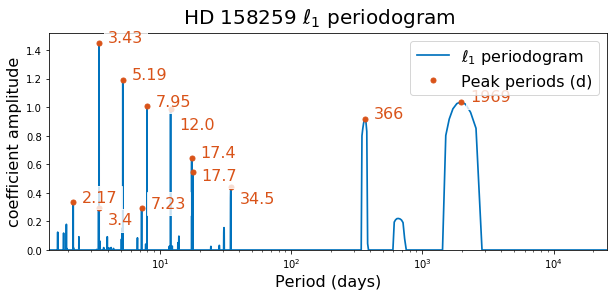

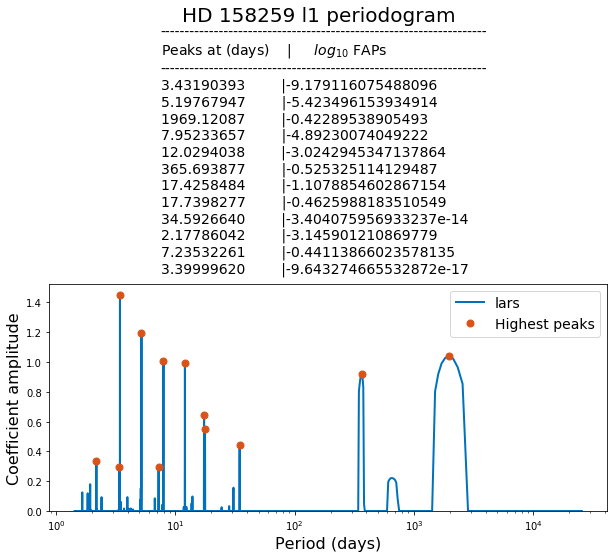

In [10]:
#We define a covariance model
sigmaW = 1. #We add in quadrature 1 m/s to the nominal SOPHIE errors 
sigmaR, tau = 3. ,6. #red noise
sigma_calib = 0.75 #No calibration noise
V = covariance_matrices.covar_mat(T,err, sigmaW, 
                                  sigmaR,sigma_calib,tau, kernel='exponential')

#To set the model use the method:
c.set_model(omegamax = 1.4*np.pi, #We will search frequencies up to 0.7 cycles/day = 3*np.pi rad/day
                  V = V,
                MH0 = offsets)#The only vector we assumed to be in the data by default is the offset

c.l1_perio(numerical_method='lars',
           significance_evaluation_methods = ['fap','evidence_laplace'],
           max_n_significance_tests=12,verbose=1)